In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from transformers import AutoTokenizer
from sklearn.metrics import f1_score

import torch
import torchvision.transforms as transforms
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.model_selection import train_test_split

import pandas as pd


/opt/miniconda3/envs/exam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ds = load_dataset("EduardoPacheco/FoodSeg103")

In [4]:
train, validation = ds["train"], ds["validation"]

train, validation

(Dataset({
     features: ['image', 'label', 'classes_on_image', 'id'],
     num_rows: 4983
 }),
 Dataset({
     features: ['image', 'label', 'classes_on_image', 'id'],
     num_rows: 2135
 }))

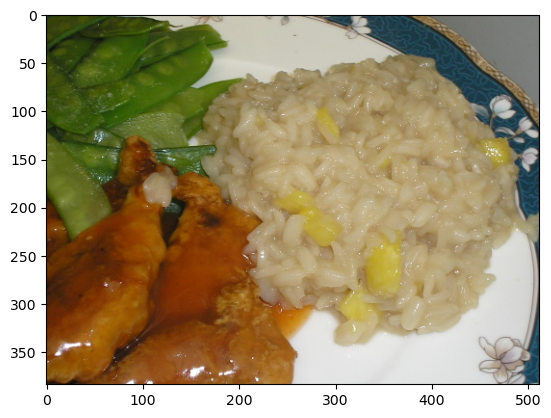

In [5]:
img = train[0]["image"]
plt.imshow(img)

In [ ]:
from PIL import Image

IMG_SIZE = 224 
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])


def preprocess_img(img,mask):
    """
    Resize image to 224x224 and convert to PyTorch tensor.
    Args:
        img: PIL Image or numpy array
    Returns:
        torch.Tensor: Image tensor ready for PyTorch
    """

    if not isinstance(img, Image.Image):
        img = Image.fromarray(img)
    if not isinstance(mask, Image.Image):
        mask = Image.fromarray(mask)
    
    return transform(img),transform(mask)


def preprocess(v):
    img_tensor, mask_tensor = preprocess_img(v["image"], v["label"])
    v["image"] = img_tensor
    v["label"] = mask_tensor
    return v


In [ ]:
small_train_ds = train.select(range(1000))
small_val_ds = validation.select(range(500))

train_torch = small_train_ds.map(preprocess)
validation_torch = small_val_ds.map(preprocess)


Map: 100%|██████████| 500/500 [00:30<00:00, 16.61 examples/s] 



In [9]:
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.DEFAULT)

model


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/cristinasemikina/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:04<00:00, 22.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def conv_block(x, filters):
    x = tf.keras.layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

def encoder_block(x, filters):
    f = conv_block(x, filters)
    p = tf.keras.layers.MaxPool2D((2,2))(f)
    return f, p

def decoder_block(x, skip, filters):
    x = tf.keras.layers.Conv2DTranspose(filters, (2,2), strides=2, padding="same")(x)
    x = tf.keras.layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def unet_model(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size + (3,))

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    return tf.keras.Model(inputs, outputs)

# Build model
IMG_SIZE = (224, 224)
NUM_CLASSES = 103   # from your dataset
model = unet_model(IMG_SIZE, NUM_CLASSES)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 14, 14,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 14, 14,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 28, 28,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ conv2d_transpose

 Total params: 31,038,375 (118.40 MB)

 Trainable params: 31,038,375 (118.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/5


2025-10-02 16:59:27.159672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


623/623 ━━━━━━━━━━━━━━━━━━━━ 329s 518ms/step - accuracy: 0.4695 - loss: 3.0665 - val_accuracy: 0.4920 - val_loss: 2.1741
Epoch 2/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 324s 520ms/step - accuracy: 0.5036 - loss: 2.1204 - val_accuracy: 0.5027 - val_loss: 2.0873
Epoch 3/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 330s 529ms/step - accuracy: 0.5119 - loss: 2.0645 - val_accuracy: 0.5010 - val_loss: 2.0967
Epoch 4/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 330s 529ms/step - accuracy: 0.5105 - loss: 2.0409 - val_accuracy: 0.5159 - val_loss: 2.0244
Epoch 5/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 332s 533ms/step - accuracy: 0.5190 - loss: 1.9889 - val_accuracy: 0.5218 - val_loss: 1.9848


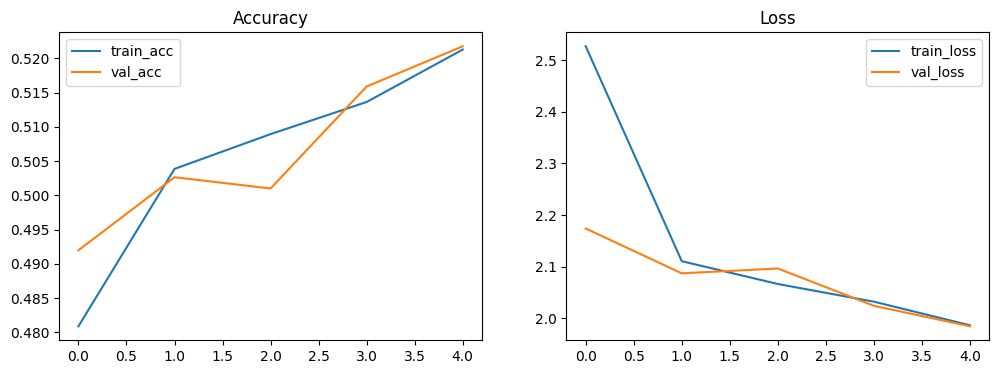

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.title("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title("Loss")
    plt.legend()

    plt.show()

plot_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


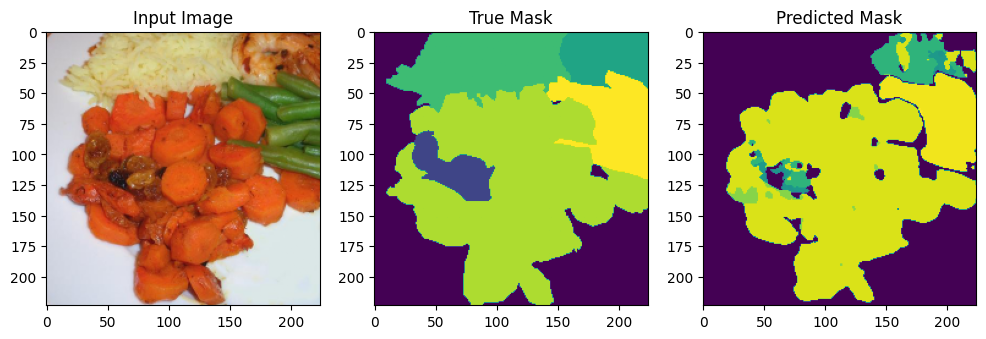

In [ ]:
import matplotlib.pyplot as plt

# Take one batch
for images, masks in val_ds.take(1):
    preds = model.predict(images)
    break

pred_mask = tf.argmax(preds, axis=-1)
pred_mask = pred_mask[..., tf.newaxis]  # shape (batch, 224, 224, 1)

def display_sample(image, true_mask, pred_mask):
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Input Image")
    plt.imshow(image)

    plt.subplot(1,3,2)
    plt.title("True Mask")
    plt.imshow(true_mask[...,0])

    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask[...,0])

    plt.show()

# Show first example in batch
display_sample(images[0], masks[0], pred_mask[0])
